<!-- ✨ Fancy Banner Section for GitHub README ✨ -->

<div style="background: linear-gradient(to right, #fceabb, #f8b500); padding: 30px; text-align: center; border-radius: 10px; color: black;">

  <h1>🛵🍕 <strong>Food Delivery Estimator</strong> 🕓📦</h1>
  <h3><em>Estimating how long your food will take to arrive</em></h3>

  <hr style="width: 50%; margin: 20px auto; border: 1px solid #f8b500;" />

  <p style="font-size: 1.1em;">
    🎯 <strong>Built by: <a href="#" style="color: black; text-decoration: none;">Thuy Huynh</a></strong><br/>
    ⏰ Delivery time estimates &nbsp;|&nbsp; 🚀 Real-time accuracy &nbsp;|&nbsp; 🤖 ML-driven insights
  </p>

</div>


<!-- 🛍️ Food Delivery Time Estimator – Styled Section -->

<div style="background: linear-gradient(to right, #fceabb, #f8b500); padding: 30px; text-align: left; border-radius: 10px; color: black;">

<h3>🛍️ Food Delivery Time Estimator & Analytics using ML 📦</h3>

<p>
This project focuses on estimating the <strong>delivery time duration</strong> for food orders based on a variety of factors such as delivery distance, traffic conditions, and the mode of transportation used by the driver. The model is trained on <a href="https://www.kaggle.com/datasets/gauravmalik26/food-delivery-dataset" style="color: black; text-decoration: underline;"><strong>Food Delivery Dataset</strong></a>, which provides a simulated representation of real-world delivery scenarios.
</p>

<p>
Key benefits include:

- Fewer late delivery complaints  
- Smarter driver and route assignment  
- Real-time, data-backed ETA predictions  
- Increased customer trust through transparency  

Additionally, the project integrates basic analytics on product data, demonstrating how machine learning can enhance the full food delivery pipeline — from logistics to real-time tracking.
</p>

</div>


<a id="c_table"></a> 

<div style="background: linear-gradient(to right, #fceabb, #f8b500); padding: 30px; text-align: left; border-radius: 10px; color: black;">

<h3 align="left"><font color=black>Table of Contents:</font></h3>
<font color=black>
        
* [1 | Libraries & Setup ⚙️](#lib)  
* [2 | Exploring the Dataset 🗄️](#data)  
* [3 | Preprocessing 🎓](#preprocessing)  
* [4 | YOLOv11 🧠](#yolo_model)  
* [5 | Model Evaluation & Metrics 📈](#metrics)  
* [6 | Predictions on Images 🖼️](#pred_images)  
* [7 | Predictions on Video 🎥](#pred_video)   
* [8 | Final Thoughts & Takeaways 📝](#summary)  

<a id="lib"></a>
# <p style="background: linear-gradient(to right, #fceabb, #f8b500); padding: 30px; text-align: left; border-radius: 10px; color: black;">1 - Libraries & Setup ⚙️</p>

⬆️ [Table of Contents](#c_table)

In [519]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.nonparametric.smoothers_lowess import lowess

In [520]:
# Loading the data
df_train = pd.read_csv('D:/thuy-qlrr/Breakthrought/Delivery/train.csv')
df_test = pd.read_csv('D:/thuy-qlrr/Breakthrought/Delivery/test.csv')
label_test = pd.read_csv('D:/thuy-qlrr/Breakthrought/Delivery/Sample_Submission.csv')

In [521]:
df_test = df_test.merge(label_test, on= 'ID', how = 'left')
df_test = df_test.rename(columns={'Time_taken (min)': 'target'})
df_train = df_train.rename(columns={'Time_taken(min)': 'target'})
df = pd.concat([df_train, df_test])

In [522]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56992 entries, 0 to 11398
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           56992 non-null  object 
 1   Delivery_person_ID           56992 non-null  object 
 2   Delivery_person_Age          56992 non-null  object 
 3   Delivery_person_Ratings      56992 non-null  object 
 4   Restaurant_latitude          56992 non-null  float64
 5   Restaurant_longitude         56992 non-null  float64
 6   Delivery_location_latitude   56992 non-null  float64
 7   Delivery_location_longitude  56992 non-null  float64
 8   Order_Date                   56992 non-null  object 
 9   Time_Orderd                  56992 non-null  object 
 10  Time_Order_picked            56992 non-null  object 
 11  Weatherconditions            56992 non-null  object 
 12  Road_traffic_density         56992 non-null  object 
 13  Vehicle_condition    

In [523]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Order_Month'] = df['Order_Date'].dt.to_period('M').astype(str)
df['Order_Month'].value_counts(normalize = True)

C:\Users\thuyhdk\AppData\Local\Temp\4\ipykernel_17784\2592546587.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')


Order_Month
2022-03    0.700098
2022-02    0.159882
2022-04    0.140020
Name: proportion, dtype: float64

In [524]:
# Train test_split
df_train = df[df['Order_Month'].isin(['2022-02', '2022-03'])].copy()
df_test = df[df['Order_Month'] == '2022-04'].copy()

In [525]:
## DATA CLEANING


# Step 1: Replace 'NaN ' string values with actual np.nan
class ReplaceFakeNaN(BaseEstimator, TransformerMixin):
    def __init__(self, fake_nan_str='NaN '):
        self.fake_nan_str = fake_nan_str

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.copy().replace(self.fake_nan_str, np.nan)


# Step 2: Convert columns to numeric and impute missing values with median
class NumericFixAndMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.imputer = SimpleImputer(strategy='median')

    def fit(self, X, y=None):
        X_temp = X.copy()
        X_temp[self.columns] = X_temp[self.columns].apply(pd.to_numeric, errors='coerce')
        self.imputer.fit(X_temp[self.columns])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = X_copy[self.columns].apply(pd.to_numeric, errors='coerce')
        X_copy[self.columns] = self.imputer.transform(X_copy[self.columns])
        return X_copy


# Step 3: Compute time difference and fill missing values with its median
class TimeDifferenceCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, start_col='Time_Orderd', end_col='Time_Order_picked', new_col='Time_Difference_Minutes'):
        self.start_col = start_col
        self.end_col = end_col
        self.new_col = new_col
        self.median_value_ = None

    def fit(self, X, y=None):
        start_time = pd.to_datetime(X[self.start_col], format='%H:%M:%S', errors='coerce')
        end_time = pd.to_datetime(X[self.end_col], format='%H:%M:%S', errors='coerce')

        diff_minutes = (end_time - start_time).dt.total_seconds() / 60
        diff_minutes = diff_minutes.where(diff_minutes >= 0, diff_minutes + 24 * 60)

        self.median_value_ = diff_minutes.median()
        return self

    def transform(self, X):
        X_copy = X.copy()
        start_time = pd.to_datetime(X_copy[self.start_col], format='%H:%M:%S', errors='coerce')
        end_time = pd.to_datetime(X_copy[self.end_col], format='%H:%M:%S', errors='coerce')

        diff_minutes = (end_time - start_time).dt.total_seconds() / 60
        diff_minutes = diff_minutes.where(diff_minutes >= 0, diff_minutes + 24 * 60)

        X_copy[self.new_col] = diff_minutes.fillna(self.median_value_)
        return X_copy


# Step 4: Calculate Haversine distance between Restaurant and Delivery location
class DistanceCalculator(BaseEstimator, TransformerMixin):
    def __init__(self,
                 lat1_col='Restaurant_latitude',
                 lon1_col='Restaurant_longitude',
                 lat2_col='Delivery_location_latitude',
                 lon2_col='Delivery_location_longitude',
                 new_col='Distance_km'):
        self.lat1_col = lat1_col
        self.lon1_col = lon1_col
        self.lat2_col = lat2_col
        self.lon2_col = lon2_col
        self.new_col = new_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        lat1 = np.radians(X_copy[self.lat1_col])
        lon1 = np.radians(X_copy[self.lon1_col])
        lat2 = np.radians(X_copy[self.lat2_col])
        lon2 = np.radians(X_copy[self.lon2_col])

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))

        R = 6371.0
        distance = R * c

        X_copy[self.new_col] = distance

        return X_copy


# Step 5: Clean and convert target column
class TargetCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, target_col='target'):
        self.target_col = target_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.target_col] = (
            X_copy[self.target_col]
            .astype(str)
            .str.replace(r'\(min\)', '', regex=True)
            .str.strip()
        )
        X_copy[self.target_col] = pd.to_numeric(X_copy[self.target_col], errors='coerce')
        return X_copy


# Step 6: Select only needed features
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keep_columns):
        self.keep_columns = keep_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.keep_columns].copy()


# Step 7: Cap outliers in 'Distance_km' by upper quartile using IQR method
class DistanceOutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, column='Distance_km'):
        self.column = column
        self.upper_bound_ = None

    def fit(self, X, y=None):
        Q1 = X[self.column].quantile(0.25)
        Q3 = X[self.column].quantile(0.75)
        IQR = Q3 - Q1
        self.upper_bound_ = Q3 + 1.5 * IQR
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = np.where(
            X_copy[self.column] > self.upper_bound_,
            self.upper_bound_,
            X_copy[self.column]
        )
        return X_copy

# Step 8: fillna for Categorical      
class ReplaceMissingConditions(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # No fitting needed
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X[col] = X[col].replace("conditions NaN", np.nan)
                X[col] = X[col].fillna("missing")
        return X

# Step 9: Custom transformer for explicit ordinal mapping for City
class EncodeCityOrdinal(BaseEstimator, TransformerMixin):
    def __init__(self, column='City'):
        self.column = column
        self.mapping = {
            'missing': 0,
            'Semi-Urban ': 1,
            'Urban ': 2,
            'Metropolitian ': 3
        }
    
    def fit(self, X, y=None):
        return self  # No fitting needed
    
    def transform(self, X):
        X = X.copy()
        X[self.column] = X[self.column].map(self.mapping).fillna(0)
        return X

# Step 10: Custom transformer for explicit ordinal mapping for Road_traffic_density
class EncodeTrafficOrdinal(BaseEstimator, TransformerMixin):
    def __init__(self, column='Road_traffic_density'):
        self.column = column
        self.mapping = {
            'missing': 0,
            'Low ': 1,
            'Medium ': 2,
            'High ': 3,
            'Jam ': 4
        }
    
    def fit(self, X, y=None):
        return self  # No fitting needed
    
    def transform(self, X):
        X = X.copy()
        X[self.column] = X[self.column].map(self.mapping).fillna(0)
        return X

# Step 11: Cleaning Festival
class EncodeFestivalcOrdinal(BaseEstimator, TransformerMixin):
    def __init__(self, column='Festival'):
        self.column = column
        self.mapping = {
            'missing': 0,
            'Yes ': 1,
            'No ': 0,
        }
    
    def fit(self, X, y=None):
        return self  # No fitting needed
    
    def transform(self, X):
        X = X.copy()
        X[self.column] = X[self.column].map(self.mapping).fillna(0)
        return X

# Final preprocessing pipeline
data_cleaning_pipeline = Pipeline([
    ('replace_fake_nan', ReplaceFakeNaN(fake_nan_str='NaN ')),
    ('numeric_fix_and_impute', NumericFixAndMedianImputer(columns=['Delivery_person_Age', 'Delivery_person_Ratings','Vehicle_condition','multiple_deliveries'])),
    ('compute_time_diff', TimeDifferenceCalculator(
        start_col='Time_Orderd',
        end_col='Time_Order_picked',
        new_col='Order_picked_length'
    )),
    ('calculate_distance', DistanceCalculator(
        lat1_col='Restaurant_latitude',
        lon1_col='Restaurant_longitude',
        lat2_col='Delivery_location_latitude',
        lon2_col='Delivery_location_longitude',
        new_col='Distance_km'
    )),
    ('clean_target', TargetCleaner(target_col='target')),
    ('feature_selector', FeatureSelector(keep_columns=[
        'Delivery_person_Age', 'Delivery_person_Ratings',
        'Weatherconditions', 'Road_traffic_density', 'Vehicle_condition',
        'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries',
        'Festival', 'City', 'Order_picked_length', 'Distance_km', 'target'
    ])),
    ('cap_distance_outliers', DistanceOutlierCapper(column='Distance_km')),
    ('replace_missing', ReplaceMissingConditions(columns= ['Weatherconditions', 'Road_traffic_density','Type_of_order','Type_of_vehicle','Festival','City'])),
    ('city_ordinal_encoder', EncodeCityOrdinal(column='City')),
    ('traffic_ordinal_encoder', EncodeTrafficOrdinal(column='Road_traffic_density')),
    ('festival_encoder', EncodeFestivalcOrdinal(column='Festival'))
])


In [526]:
df_train = data_cleaning_pipeline.fit_transform(df_train)

In [527]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Age,49012.0,29.579511,5.691244,15.000000,25.000000,30.000000,34.000000,50.000000
Delivery_person_Ratings,49012.0,4.637297,0.329548,1.000000,4.600000,4.700000,4.800000,6.000000
Road_traffic_density,49012.0,2.352057,1.267897,0.000000,1.000000,2.000000,4.000000,4.000000
Vehicle_condition,49012.0,1.024892,0.838924,0.000000,0.000000,1.000000,2.000000,3.000000
multiple_deliveries,49012.0,0.752918,0.568103,0.000000,0.000000,1.000000,1.000000,3.000000
Festival,49012.0,0.019587,0.138578,0.000000,0.000000,0.000000,0.000000,1.000000
City,49012.0,2.689566,0.616401,0.000000,2.000000,3.000000,3.000000,3.000000
Order_picked_length,49012.0,10.004489,4.002481,5.000000,5.000000,10.000000,15.000000,15.000000
Distance_km,49012.0,9.927220,5.859099,1.465067,4.663567,9.312838,13.766117,27.419942
target,49012.0,26.296573,9.209710,10.000000,19.000000,25.000000,32.000000,54.000000


In [528]:
df_train.select_dtypes(include='object').describe().T

,count,unique,top,freq
Weatherconditions,49012,7,conditions Cloudy,8124
Type_of_order,49012,4,Snack,12349
Type_of_vehicle,49012,4,motorcycle,28409


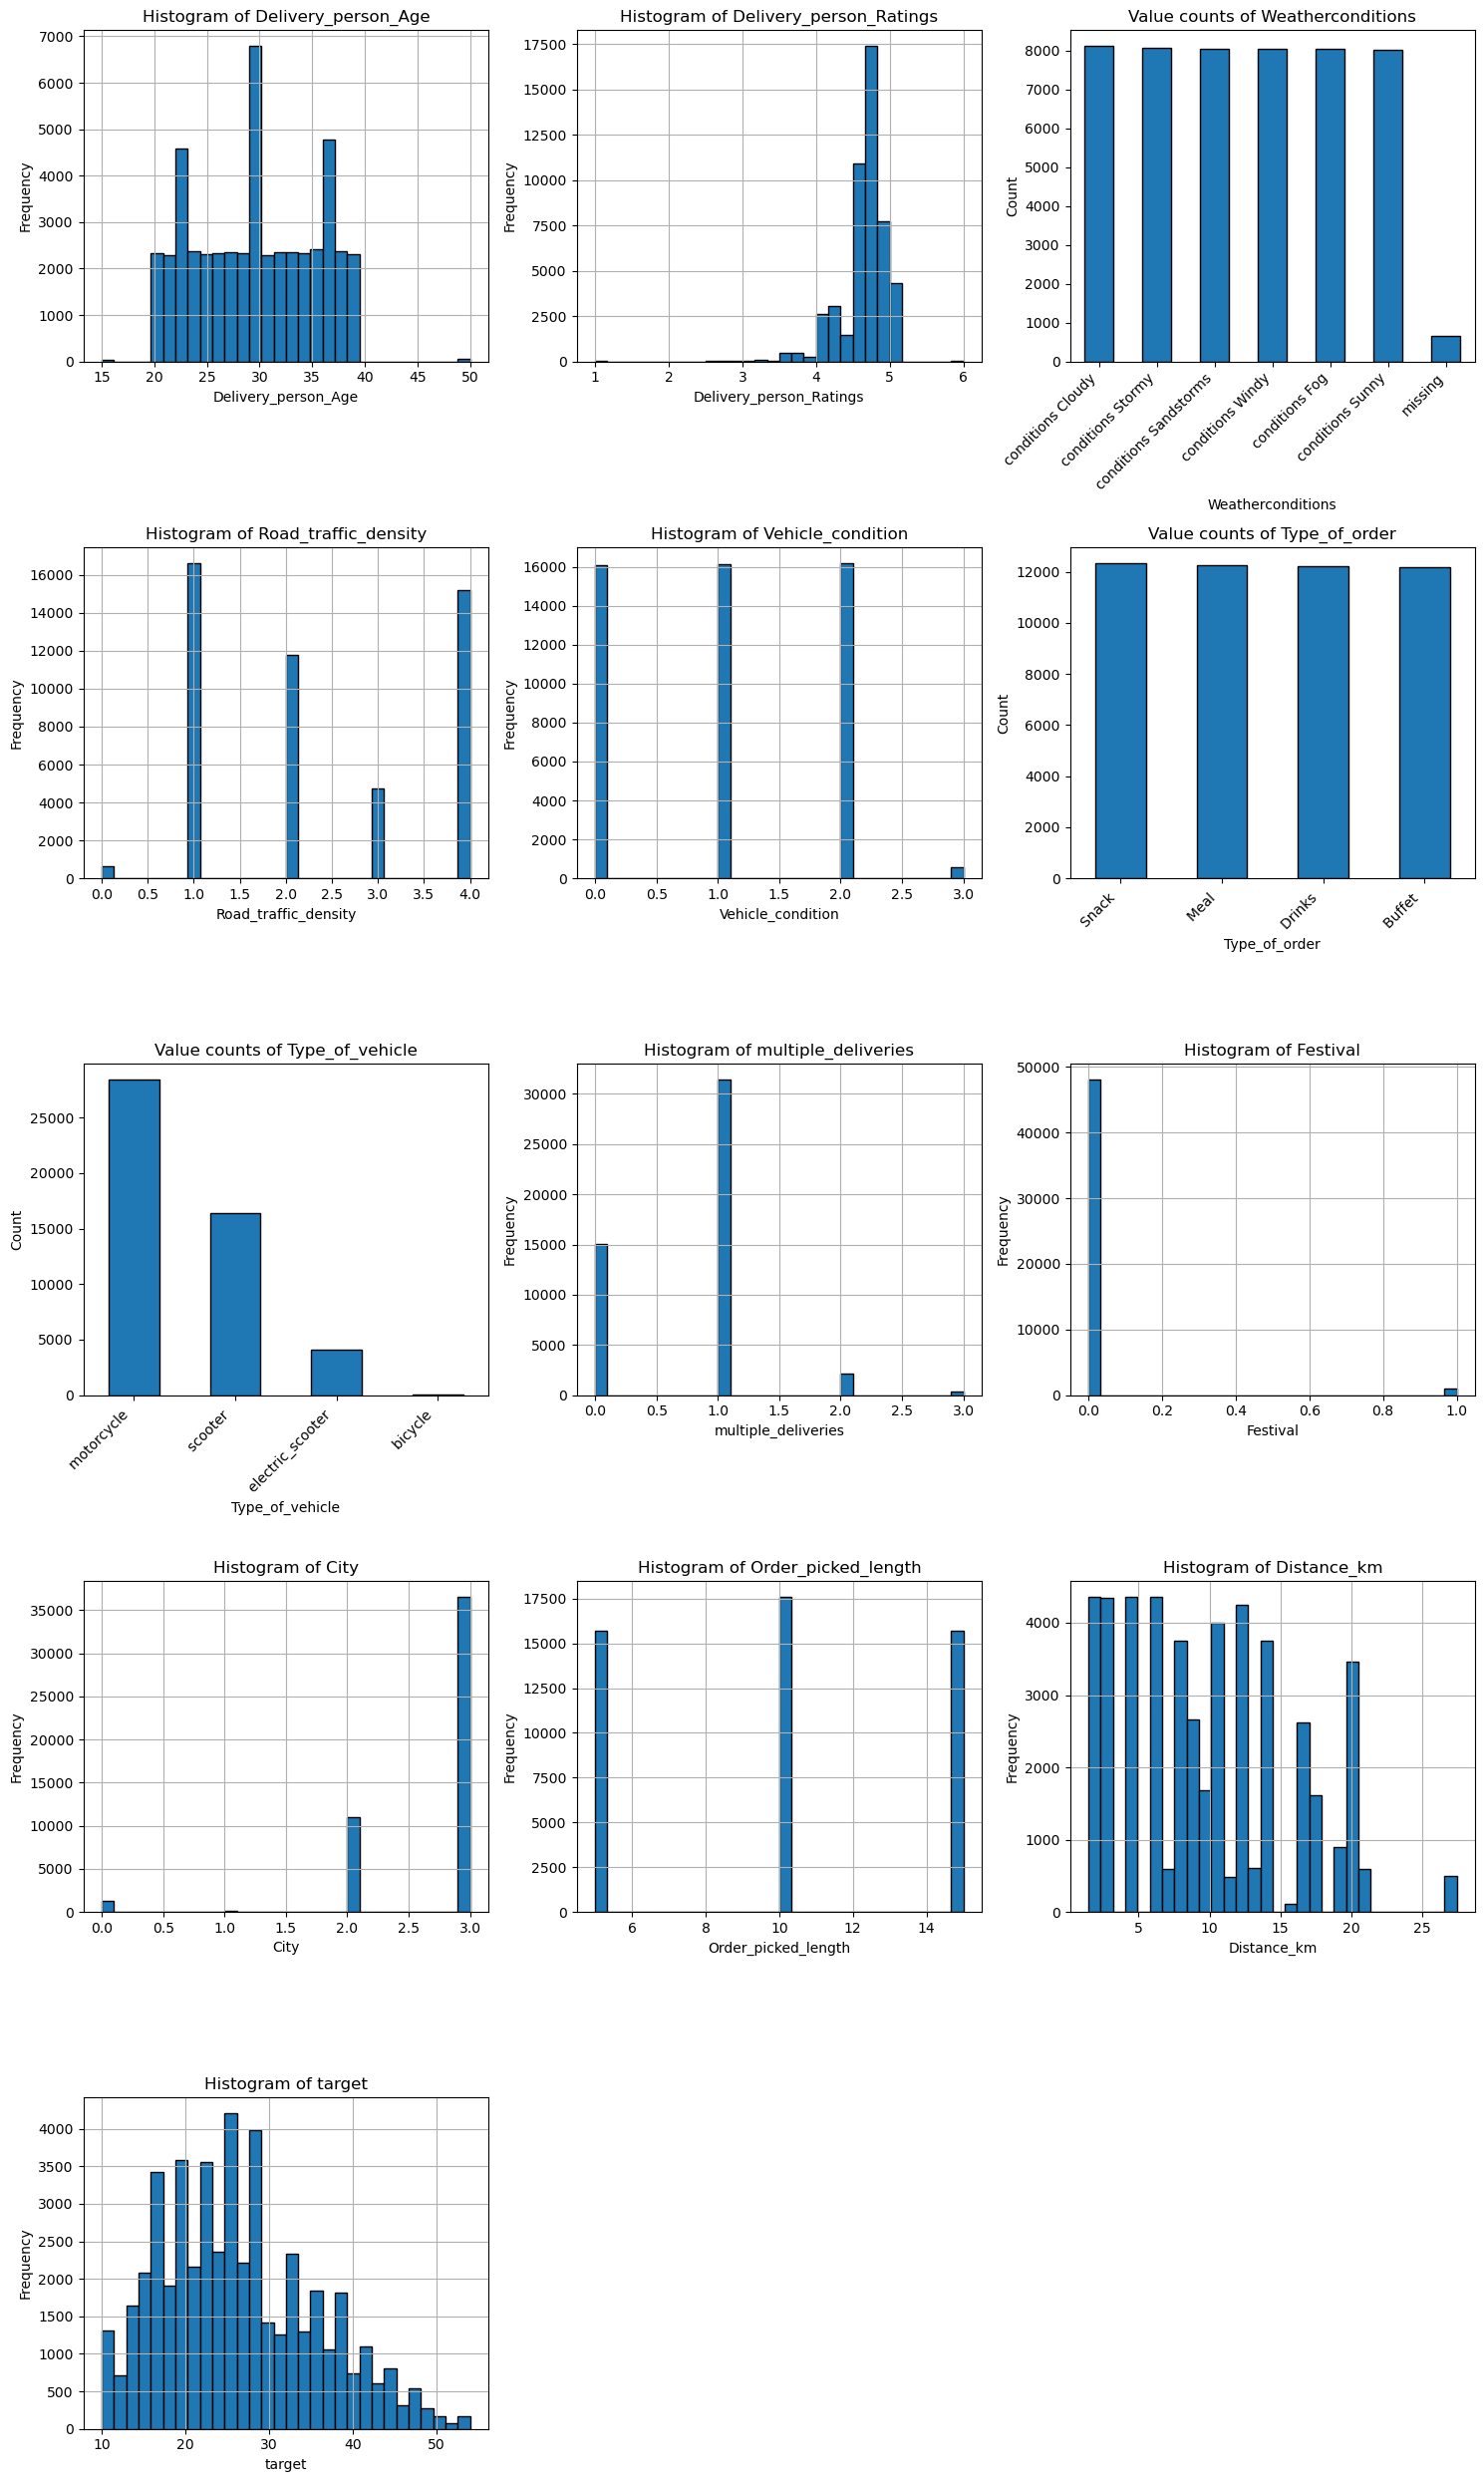

In [529]:
import matplotlib.pyplot as plt

def plot_all_histograms(df, bins=30, figsize=(15, 5)):
    """
    Plot histograms for all columns in the DataFrame.
    Numeric columns get histograms,
    Object columns get bar plots of value counts.
    """
    import math

    cols = df.columns
    n_cols = 3  # Number of plots per row
    n_rows = math.ceil(len(cols) / n_cols)

    plt.figure(figsize=(figsize[0], n_rows * figsize[1]))

    for i, col in enumerate(cols, 1):
        plt.subplot(n_rows, n_cols, i)

        if pd.api.types.is_numeric_dtype(df[col]):
            # Numeric column: histogram
            df[col].hist(bins=bins, edgecolor='black')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.title(f'Histogram of {col}')
        else:
            # Object or categorical: bar plot of value counts
            vc = df[col].value_counts(dropna=False)
            vc.plot(kind='bar', edgecolor='black')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.title(f'Value counts of {col}')
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()

    plt.show()

plot_all_histograms(df_train)

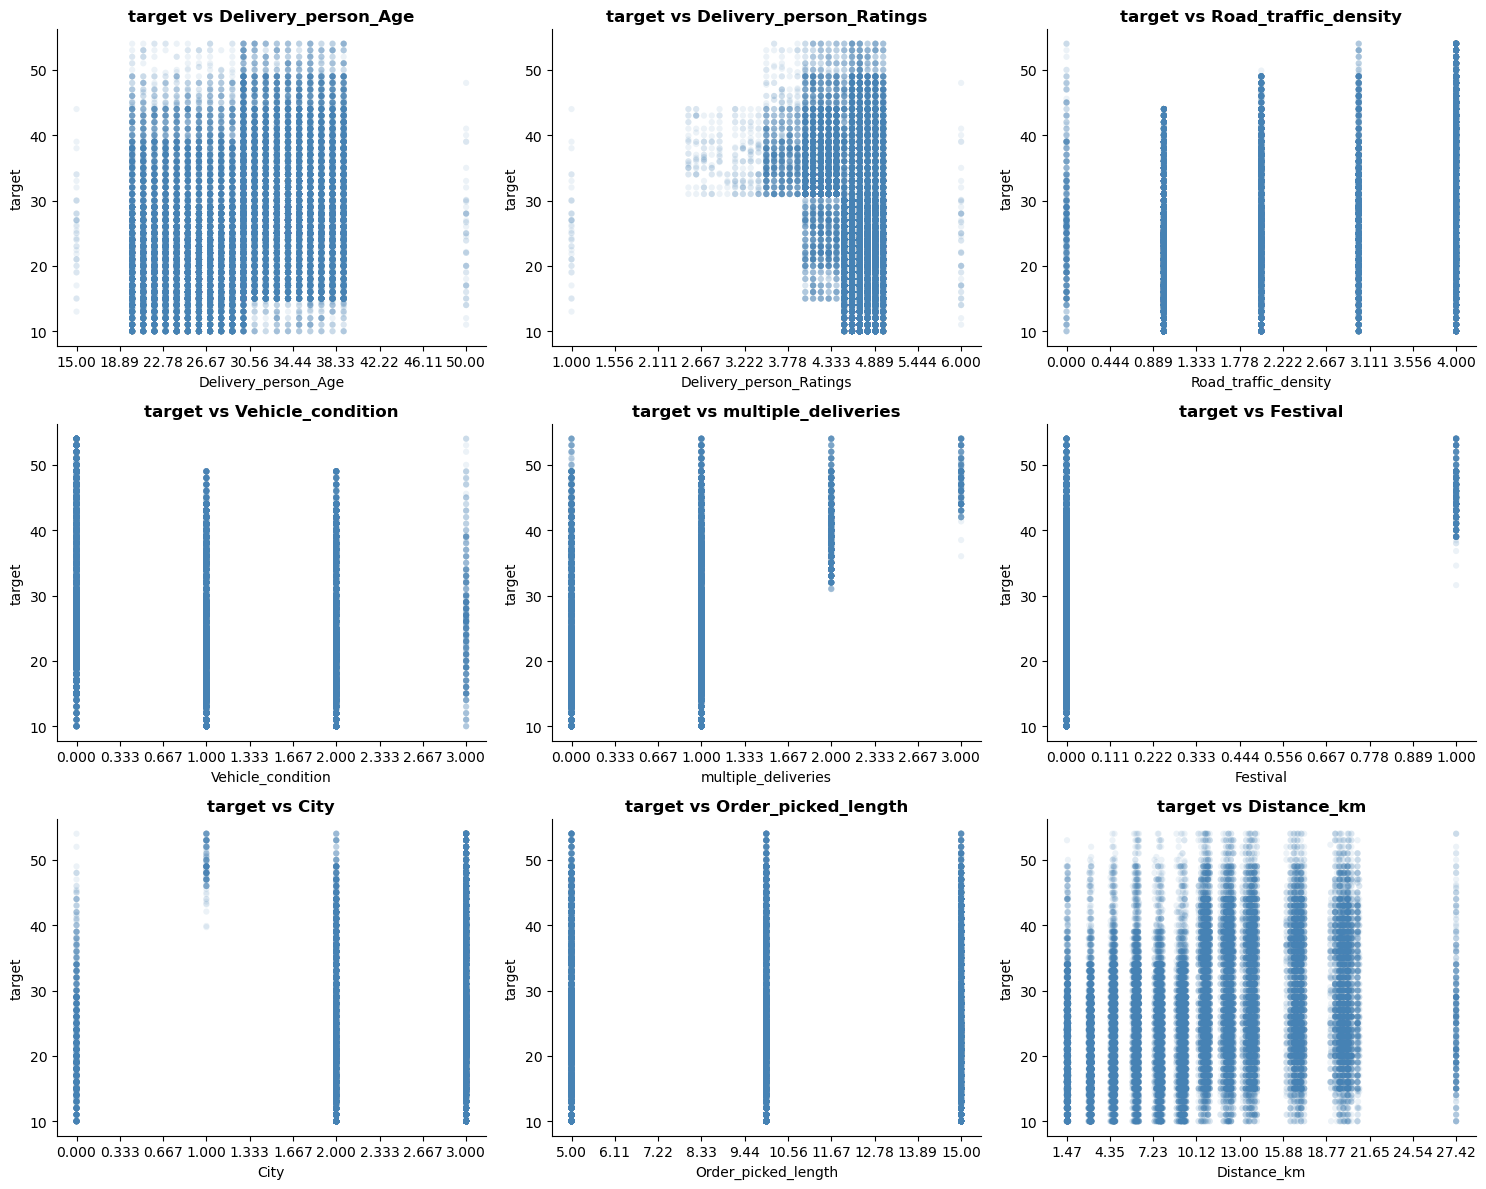

In [530]:

def plot_numeric_features_vs_target_wide_xaxis(df, target_col='target', max_cols=3, figsize_per_plot=(5,4)):
    numeric_features = [c for c in df.columns if c != target_col and pd.api.types.is_numeric_dtype(df[c])]
    n_features = len(numeric_features)
    n_cols = max_cols
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows))
    if n_rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, feature in enumerate(numeric_features):
        ax = axes[i]
        x = df[feature]
        y = df[target_col]
        
        ax.scatter(x, y, alpha=0.1, s=20, color='steelblue', edgecolors='none')
        ax.set_xlabel(feature)
        ax.set_ylabel(target_col)
        ax.set_title(f"{target_col} vs {feature}", fontsize=12, weight='bold')
        
        # Set wider x-limits (extend 5% beyond min and max)
        x_min, x_max = x.min(), x.max()
        x_range = x_max - x_min
        ax.set_xlim(x_min - 0.05*x_range, x_max + 0.05*x_range)
        
        # Show more ticks: set ticks at regular intervals
        num_ticks = 10  # increase or decrease as you want
        tick_positions = np.linspace(x_min, x_max, num_ticks)
        ax.set_xticks(tick_positions)
        
        # Clean style
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)
        ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Remove unused axes
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


plot_numeric_features_vs_target_wide_xaxis(df_train, target_col='target')



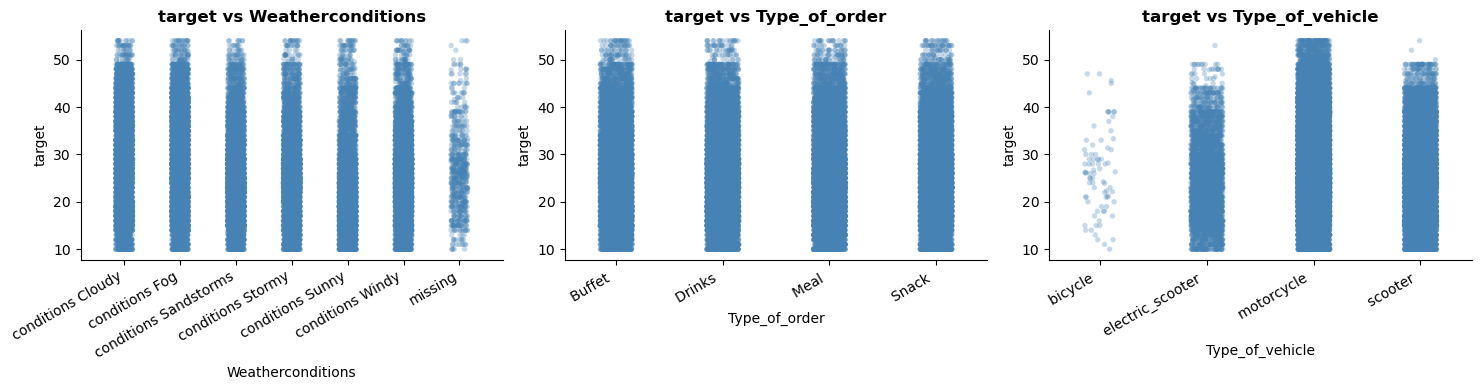

In [531]:
def plot_categorical_features_vs_target(df, target_col='target', max_cols=3, figsize_per_plot=(5, 4)):
    """
    Create scatterplots of target vs each categorical feature with jitter.
    Clean and minimal: no trend lines, no extra clutter.
    """
    # Select only categorical features
    cat_features = [c for c in df.columns if c != target_col and df[c].dtype == 'object']
    
    n_features = len(cat_features)
    n_cols = max_cols
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows))
    if n_rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, feature in enumerate(cat_features):
        ax = axes[i]
        x = df[feature].astype('category')
        y = df[target_col]
        codes = x.cat.codes  # convert categories to numbers
        labels = x.cat.categories
        
        # Add jitter
        jittered_x = codes + (np.random.rand(len(codes)) - 0.5) * 0.3
        
        # Scatter plot
        ax.scatter(jittered_x, y, alpha=0.3, s=15, color='steelblue', edgecolors='none')
        
        # Set category labels
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=30, ha='right')
        ax.set_xlabel(feature)
        ax.set_ylabel(target_col)
        ax.set_title(f"{target_col} vs {feature}", fontsize=12, weight='bold')
        
        # Clean up style
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.margins(x=0.1)
    
    # Remove unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_categorical_features_vs_target(df_train, target_col='target')


In [532]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49012 entries, 0 to 11398
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      49012 non-null  float64
 1   Delivery_person_Ratings  49012 non-null  float64
 2   Weatherconditions        49012 non-null  object 
 3   Road_traffic_density     49012 non-null  int64  
 4   Vehicle_condition        49012 non-null  float64
 5   Type_of_order            49012 non-null  object 
 6   Type_of_vehicle          49012 non-null  object 
 7   multiple_deliveries      49012 non-null  float64
 8   Festival                 49012 non-null  int64  
 9   City                     49012 non-null  int64  
 10  Order_picked_length      49012 non-null  float64
 11  Distance_km              49012 non-null  float64
 12  target                   49012 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 5.2+ MB


In [533]:

class StandardScaleNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

class OneHotEncodeCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.feature_names_ = None
    
    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        self.feature_names_ = self.encoder.get_feature_names_out(self.columns)
        return self
    
    def transform(self, X):
        X = X.copy()
        encoded = self.encoder.transform(X[self.columns])
        # Remove original categorical columns
        X = X.drop(columns=self.columns)
        # Append encoded columns as a DataFrame with proper columns
        import pandas as pd
        encoded_df = pd.DataFrame(encoded, columns=self.feature_names_, index=X.index)
        X = pd.concat([X, encoded_df], axis=1)
        return X

# Example pipeline
data_scaling = Pipeline([
    ('scale_numeric', StandardScaleNumeric(columns=['Delivery_person_Age', 'Delivery_person_Ratings','Road_traffic_density','Vehicle_condition','multiple_deliveries', 'City', 'Order_picked_length', 'Distance_km'])),
    ('onehot_encode', OneHotEncodeCategorical(columns=['Weatherconditions', 'Type_of_order', 'Type_of_vehicle']))
])


In [534]:
df_train=data_scaling.fit_transform(df_train)
df_test = data_cleaning_pipeline.fit_transform(df_test)
df_test = data_scaling.fit_transform(df_test)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [535]:
from sklearn.linear_model import LinearRegression
X_train = df_train.drop(columns='target')
y_train = df_train['target']
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


LinearRegression()

RMSE: 5.88


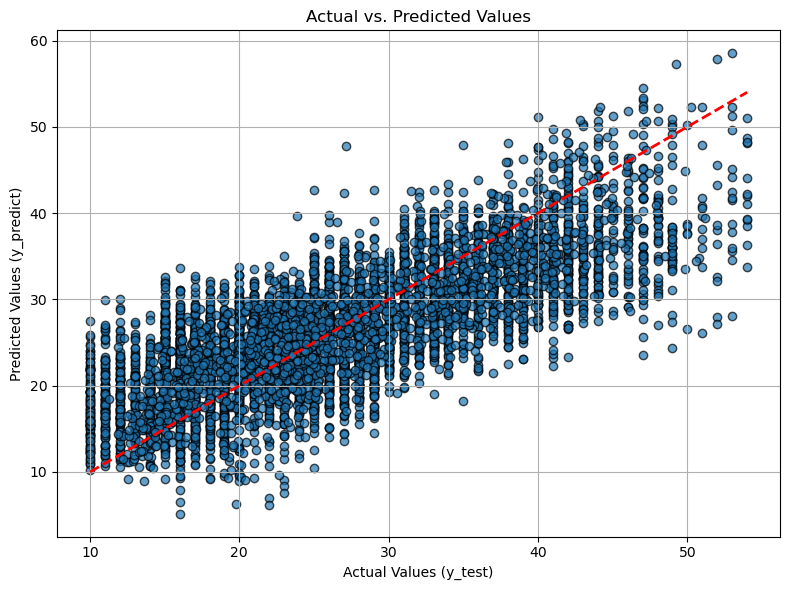

In [536]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Compute predictions and RMSE

X_test = df_test.drop(columns='target')
y_test = df_test['target']

y_predict = lin_reg.predict(X_test)

lin_mse = mean_squared_error(y_test, y_predict)
lin_rmse = np.sqrt(lin_mse)
print(f"RMSE: {lin_rmse:.2f}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_predict, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_predict)')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()


In [537]:
some_data = X_test.iloc[:5]
some_labels = y_test.iloc[:5]
print("Predictions:", lin_reg.predict(some_data))
print("Labels:", list(some_labels))


Predictions: [27.33198102 30.96172894 23.98033115 16.11324037 19.37937167]
Labels: [21.0, 20.0, 18.0, 12.0, 26.0]


In [538]:
full_pipeline = FeatureUnion(transformer_list=[
 ("data_cleaning", data_cleaning_pipeline),
 ("data_scaling", data_scaling),
 ])

RMSE: 5.14


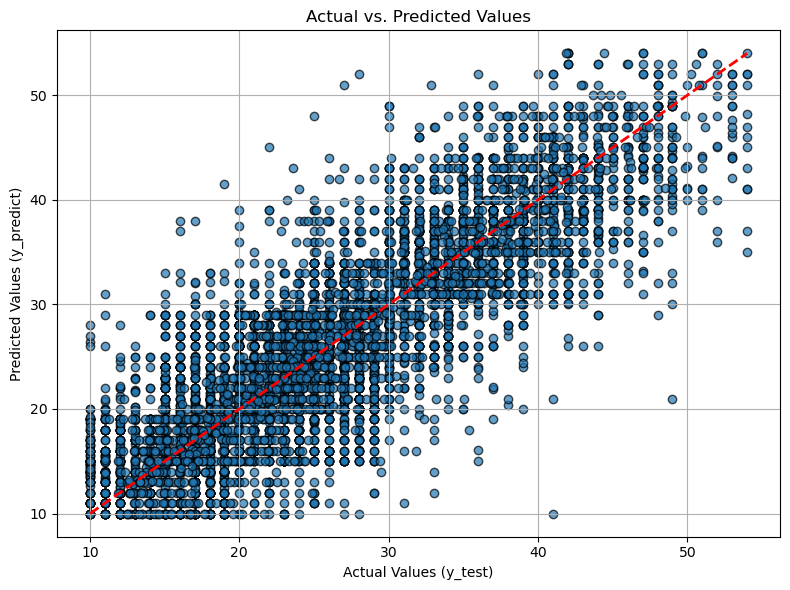

In [539]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state = 123)
tree_reg.fit(X_train, y_train)

y_predict = tree_reg.predict(X_test)

tree_mse = mean_squared_error(y_test, y_predict)
tree_rmse = np.sqrt(tree_mse)
print(f"RMSE: {tree_rmse:.2f}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_predict, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_predict)')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()


In [540]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [5.22778032 5.27826894 5.23637244 5.34698668 5.36349235 5.24576153
 5.23722997 5.22809167 4.17511616 4.18454717]
Mean: 5.052364723003614
Standard deviation: 0.438679207651187


In [541]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [6.13961789 6.24558084 6.20359184 6.13461245 6.17964444 6.12904869
 6.22864065 6.17774235 4.72641708 4.58554237]
Mean: 5.875043860464151
Standard deviation: 0.6114516578642301


In [542]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state = 123)
forest_reg.fit(X_train, y_train)


RandomForestRegressor(random_state=123)

In [543]:
y_predict = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, y_predict)
forest_rmse = np.sqrt(forest_mse)
print(f"RMSE: {forest_rmse:.2f}")

RMSE: 3.74


In [544]:
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [3.974989   3.99485209 3.98822045 3.99447252 4.08382338 4.02555552
 3.99166991 4.01670778 2.13055854 2.17907131]
Mean: 3.6379920498194833
Standard deviation: 0.7422226391972536


In [545]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [546]:
grid_search.best_params_


{'max_features': 8, 'n_estimators': 30}

In [547]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


4.9963224100407135 {'max_features': 2, 'n_estimators': 3}
4.315064118391334 {'max_features': 2, 'n_estimators': 10}
4.076898217927927 {'max_features': 2, 'n_estimators': 30}
4.513101245715468 {'max_features': 4, 'n_estimators': 3}
3.9774704458108103 {'max_features': 4, 'n_estimators': 10}
3.816325922724495 {'max_features': 4, 'n_estimators': 30}
4.325315561659099 {'max_features': 6, 'n_estimators': 3}
3.8615126871963024 {'max_features': 6, 'n_estimators': 10}
3.726478931717235 {'max_features': 6, 'n_estimators': 30}
4.2494868875060225 {'max_features': 8, 'n_estimators': 3}
3.8412479081506334 {'max_features': 8, 'n_estimators': 10}
3.7150508323437625 {'max_features': 8, 'n_estimators': 30}
4.9859581623380285 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
4.297080354898059 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
4.681760436809779 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
4.135150848565157 {'bootstrap': False, 'max_features': 3, 'n_estimato

In [548]:
optimal_reg = grid_search.best_estimator_
y_predict = optimal_reg.predict(X_test)
optimal_mse = mean_squared_error(y_test, y_predict)
optimal_rmse = np.sqrt(optimal_mse)
print(f"RMSE: {optimal_rmse:.2f}")

RMSE: 3.71


In [549]:
optimal_scores = cross_val_score(optimal_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
optimal_rmse_scores = np.sqrt(-optimal_scores)
display_scores(optimal_rmse_scores)

Scores: [3.97938305 4.02412609 3.98731854 3.96950746 4.0939596  3.99426102
 3.9518914  4.03929502 2.06726371 2.09284029]
Mean: 3.619984617112317
Standard deviation: 0.7709363423425601


In [550]:
some_data = X_test.iloc[5:10]
some_labels = y_test.iloc[5:10]
print("Predictions:", optimal_reg.predict(some_data))
print("Labels:", list(some_labels))


Predictions: [28.71558333 14.58608333 15.01963889 32.06552778 47.34016667]
Labels: [30.0, 10.0, 11.0, 33.0, 52.0]
